STAT 479 Take-Home Exam
by Cory Suzuki, 12/6/2024

For this exam, we will implement a Convolutional Neural Network (CNN) for multi-class classification of different European Satellite images dataset where we classify different terrains from satellite images. There are a total of 10 classes: AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, and Sealake, where each of the respective classes have the numeric labels [0,1,2,...,10]. For example, 0 corresponds to AnnualCrop, 1 corresponds to Forest, and so forth. Each image is 64 by 64 pixels and since we are using RGB, we will be using 3 channels in our CNN's. We consider a deterministic (our choice) of CNN model and perform hyperparameter tuning in order to find the best set of hyperparameters for our hypothesized best model. In addition for extra analysis, we will also introduce and implement a Residual Unit CNN called ResNet-34 and compare it with our hypertuned model.


Due to the computational complexity running Convolutional Neural Networks, please do not run any of the below code without using a GPU, as the code will take more than an hour to compile for each code block. Note that the code was compiled using the Google Colab T4 cloud-based GPU to ensure faster runtime and protecting the personal machine's integrity. The results are summarized in this markdown report.

We will be conducting the following test:
$H_{o} : \text{Resnet-34 model performs worse than the base model.}$
$H_{a} : \text{Resnet-34 model performs better than the base model.}$

For preprocessing, there are no missing images or corrupted pixels in each of the images so minimal cleaning was involved. However, for this exam, an 80-10-10 data split for training, validation, and testing datasets respectively was utilized. This was achieved by randomizing the images in each of the class category folders and allocating 500 images to training (80%), 63 images to validation (10%), and 63 images to the testing folder (10%). Then the zip folder was decompressed and imported to this Python notebook via SkLearn's preprocessing library as shown below.

In [1]:
!unzip Euro_Sat_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: Euro_Sat_data/Training/Forest/Forest_233.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_234.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_235.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_236.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_237.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_238.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_239.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_24.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_240.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_241.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_242.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_243.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_244.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_245.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_246.jpg  
  inflating: Euro_Sat_data/Training/Forest/Forest_

In [2]:
!pip install keras_tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


In [3]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.4 MB/s eta 0:00:00


In [4]:
# Import all necessary libraries.

import os
import shutil
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras as keras
import keras_tuner as kt
import seaborn as sns
import optuna
from functools import partial
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from tensorflow.keras.utils import image_dataset_from_directory

In [5]:
# Upload the image data.

new_base_dir = pathlib.Path("Euro_Sat_data")

train_dataset = image_dataset_from_directory(
    new_base_dir / "Training",
    image_size=(64, 64),
    batch_size=32
)

valid_dataset = image_dataset_from_directory(
    new_base_dir / "Validation",
    image_size=(64, 64),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    new_base_dir / "Testing",
    image_size=(64, 64),
    batch_size=32,
    shuffle=False
)

Found 4991 files belonging to 10 classes.
Found 630 files belonging to 10 classes.
Found 630 files belonging to 10 classes.


In [6]:
# Checking dimensions of training, validation, and testing sets.

for data_batch1, labels_batch1 in train_dataset:
    print("data batch shape:", data_batch1.shape)
    print("labels batch shape:", labels_batch1.shape)
    break

for data_batch2, labels_batch2 in valid_dataset:
    print("data batch shape:", data_batch2.shape)
    print("labels batch shape:", labels_batch2.shape)
    break

for data_batch3, labels_batch3 in test_dataset:
    print("data batch shape:", data_batch3.shape)
    print("labels batch shape:", labels_batch3.shape)
    break

data batch shape: (32, 64, 64, 3)
labels batch shape: (32,)
data batch shape: (32, 64, 64, 3)
labels batch shape: (32,)
data batch shape: (32, 64, 64, 3)
labels batch shape: (32,)


For the construction of our first deterministic model, we use 3 channels for "RGB" images and the images are 64 by 64 pixels, thus defining our input shape. We will be using the Rescaling layer in our models by dividing by 255 in order to normalize our image data. Max Pooling in 2D is applied and we also implement 2D convolutional layers. Due to computational constraints on my personal machine, we will only be considering the "relu" activation function and keeping the output layer's activation at softmax while keeping the optimizer under the Adam optimizer. Note that if we has access to better computational resources such as physical GPU's or better CPU processors, we would be able to perform hyperparameter tuning with better optimizers. We now provide the learning curves and confusion matrix for the first model.

In [7]:
# Construction of CNN (1st model)

tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", activation="relu",
                        kernel_initializer="he_normal")
first_model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[64, 64, 3]),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

first_model.compile(loss="sparse_categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                    metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
# Compiling the 1st model and using accuracy as our target metric.

first_history = first_model.fit(
    train_dataset,
    epochs=50,
    validation_data = valid_dataset,
    verbose = 1
)

Epoch 1/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.1309 - loss: 2.3352 - val_accuracy: 0.3365 - val_loss: 1.9795
Epoch 2/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.2380 - loss: 2.0720 - val_accuracy: 0.4063 - val_loss: 1.7403
Epoch 3/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2910 - loss: 1.9424 - val_accuracy: 0.4190 - val_loss: 1.6564
Epoch 4/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.3373 - loss: 1.8079 - val_accuracy: 0.5254 - val_loss: 1.5099
Epoch 5/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.3663 - loss: 1.7579 - val_accuracy: 0.5429 - val_loss: 1.4055
Epoch 6/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.4194 - loss: 1.6242 - val_accuracy: 0.5810 - val_loss: 1.2617
Epoch 7/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4425 - loss: 1.5578 - val_accuracy: 0.6127 - val_loss: 1.1828
Epoch 8/50
156/156 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.5009 - loss: 1.4735 - val_acc

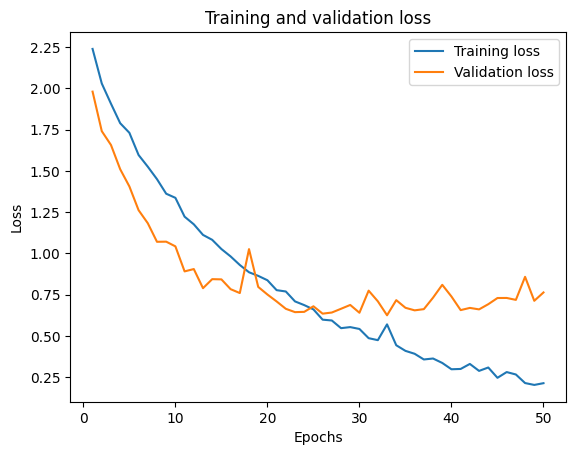

In [9]:
# Model Performance Metric Analysis 1: Training and Validation Loss Plots
loss = first_history.history['loss']
val_loss = first_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


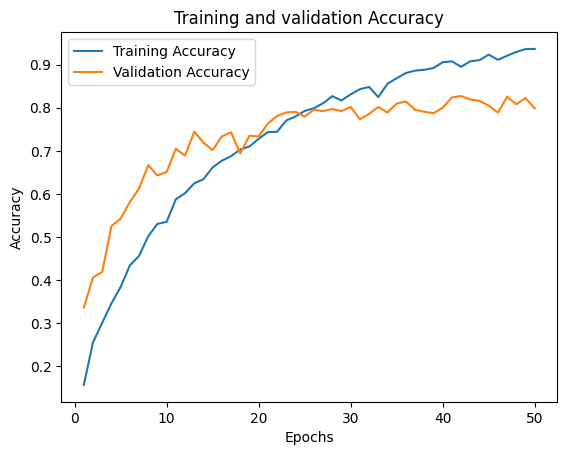

In [10]:
# Model Performance Metric Analysis 1.1: Training and Validation Set Accuracy Plot

accuracy = first_history.history['accuracy']
val_accuracy = first_history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, accuracy,  label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


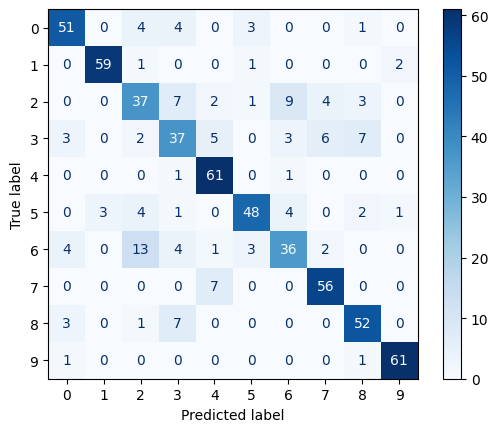

In [11]:
# Confusion Matrix of First Proposed CNN model.

# Get the true labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Make predictions
predictions = first_model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))  # Adjust 'display_labels' as needed
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [12]:
# Model Performance Metric Analysis: Test Set Accuracy for First Model

test_loss, test_accuracy = first_model.evaluate(test_dataset)

print("Test loss {:.4f}".format(test_loss))
print("Test accuracy {:.4f}".format(test_accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7830 - loss: 0.9712
Test loss 0.8880
Test accuracy 0.7905


From the above analysis of our first model, we can see that it has achieved a training accuracy of 93.23% and training loss of 0.2163. When we compare with our validation accuracy and loss learning curves above, we notice that by the elbow method, we can see that overfitting occurs around 20 epochs, so we can cut the epochs there when we evaluate our future models.

 We now attempt to perform hyperparameter tuning with different learning curve rates and different filter inputs for each of the convolutional layers. We will note that this exam does not consider different optimizers or other parameters than the aforementioned since my computer nearly crashed when running the below code. We will be using the Optuna Bayesian hyperparameter tuner for this exam since it will reduce the runtime and be less computationally expensive than GridSearch or RandomSearch. The algorithm is as follows:

 1. Build the prior (surrogate) probability model of the objective function.
 2. Run the neural network on the surrogate model and record the best set of hyperparameters.
 3. Using the objective function to be optimized, select and apply the current set of best hyperparameters.
 4. Update the accuracy score of the surrogate model with the latest results.
 
 Note that this algorithm will repeat with the current surrogate model to produce new iterative surrogates until the maximum number of trials are met.
 
  This hyperparameter tuner is based on the Bayesian framework, where the prior beliefs are represented by the previous set of optimized hyperparameters and the posterior beliefs are represented by the current trial. We perform 5 trials below and see if it yields more optimal results.

In [13]:
# Hyperparameter Tuning using the Optuna Bayesian hyperparameter tuner.

def create_model(trial):
    DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same", activation="relu",
                            kernel_initializer="he_normal")
    model = tf.keras.Sequential([
        DefaultConv2D(filters=trial.suggest_int('filters_1', 32, 128), kernel_size=7, input_shape=[64, 64, 3]),
        tf.keras.layers.Rescaling(1./255),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=trial.suggest_int('filters_2', 64, 256)),
        DefaultConv2D(filters=trial.suggest_int('filters_3', 64, 256)),
        tf.keras.layers.MaxPool2D(),
        DefaultConv2D(filters=trial.suggest_int('filters_4', 128, 512)),
        DefaultConv2D(filters=trial.suggest_int('filters_5', 128, 512)),
        tf.keras.layers.MaxPool2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=trial.suggest_int('units_1', 64, 256), activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(trial.suggest_float('dropout_1', 0.2, 0.5)),
        tf.keras.layers.Dense(units=trial.suggest_int('units_2', 32, 128), activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dropout(trial.suggest_float('dropout_2', 0.2, 0.5)),
        tf.keras.layers.Dense(units=10, activation="softmax")
    ])
    return model

# Define the objective function
def objective(trial):
    model = create_model(trial)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)),
                  metrics=["accuracy"])

    # Assuming X_train and y_train are your training data
    history = model.fit(train_dataset, epochs=10, validation_data=valid_dataset, verbose=0)

    # Evaluate the model
    accuracy = history.history['val_accuracy'][-1]
    return accuracy

# Create a study and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=5)

# Print the best hyperparameters
print(f"Best hyperparameters: {study.best_params}")

[I 2024-12-13 23:19:39,337] A new study created in memory with name: no-name-af7b12a6-cfae-4e5d-8a26-5382dfe1f719
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
<ipython-input-13-6899091ab25e>:31: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  optimizer=tf.keras.optimizers.Adam(learning_rate=trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)),
[I 2024-12-13 23:21:06,342] Trial 0 finished with value: 0.6650793552398682 and parameters: {'filters_1': 100, 'filters_2': 67, 'filters_3': 177, 'filters_4': 271, 'filters_5': 505, 'units_1': 

Best hyperparameters: {'filters_1': 100, 'filters_2': 67, 'filters_3': 177, 'filters_4': 271, 'filters_5': 505, 'units_1': 116, 'dropout_1': 0.4224975293259605, 'units_2': 45, 'dropout_2': 0.28037004068048643, 'learning_rate': 0.00020688761186807986}


After performing Bayesian Optimization for the hyperparameter tuning of our first model with the Optuna study package, we obtain the results that the best hyperparameters yield an accuracy of 66.51%, which is significantly less than our first model. This confirms that even with hyperparameter tuning, we are not guaranteed a model with a higher accuracy and lower loss than our proposed model. Therefore, we will now compare the best model so far with the Residual Network 34 (ResNet-34) model and see if it yields better results. This model has been used in Geron Aurelion's "Hands-On Machine Learning" textbook which can be found in the references section of this exam.

In [15]:
# Bonus: ResNet-34 Implementation and Analysis

tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1, padding="same",
                        kernel_initializer="he_normal", use_bias=False)

class ResidualUnit(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [16]:
resnet_model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[128, 128, 3]),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")
])

prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    resnet_model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

resnet_model.add(tf.keras.layers.GlobalAvgPool2D())
resnet_model.add(tf.keras.layers.Flatten())
resnet_model.add(tf.keras.layers.Dense(10, activation="softmax"))

resnet_model.compile(loss="sparse_categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                     metrics=["accuracy"])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
resnet_history = resnet_model.fit(
    train_dataset,
    epochs = 20,
    validation_data = valid_dataset,
    verbose = 1
)

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 55s 159ms/step - accuracy: 0.4471 - loss: 1.7154 - val_accuracy: 0.1921 - val_loss: 3.6473
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - accuracy: 0.6776 - loss: 0.9264 - val_accuracy: 0.2873 - val_loss: 3.0879
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 42ms/step - accuracy: 0.7413 - loss: 0.7236 - val_accuracy: 0.4841 - val_loss: 1.9085
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.8017 - loss: 0.5848 - val_accuracy: 0.6381 - val_loss: 1.1769
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.8511 - loss: 0.4416 - val_accuracy: 0.6571 - val_loss: 1.1733
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8662 - loss: 0.3813 - val_accuracy: 0.7270 - val_loss: 1.0254
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8951 - loss: 0.2953 - val_accuracy: 0.6302 - val_loss: 1.4354
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.8967 - loss: 0.2916 - val_

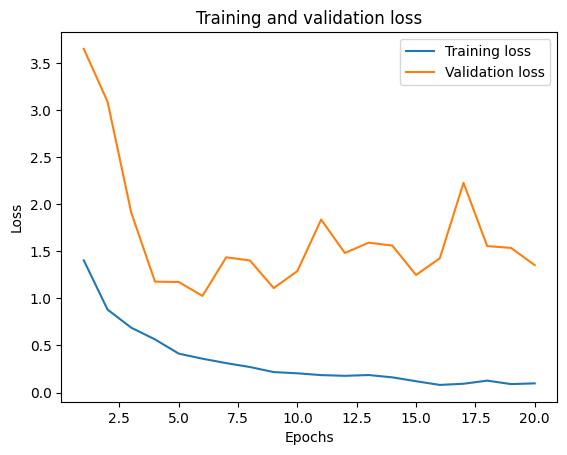

In [18]:
# Model Performance Metric Analysis for Resnet-34: Training and Validation Loss Plots
loss = resnet_history.history['loss']
val_loss = resnet_history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss,  label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


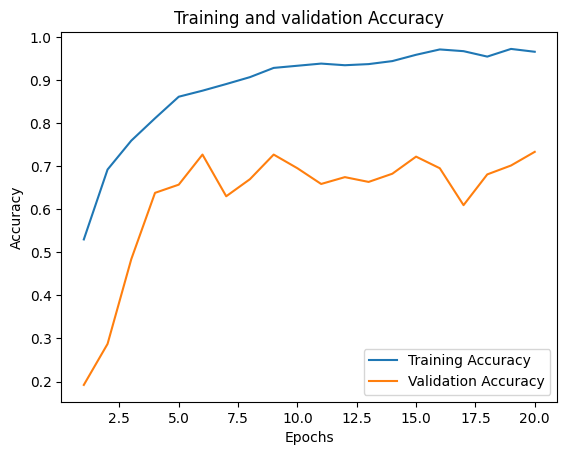

In [19]:
# Model Performance Metric Analysis for Resnet-34: Training and Validation Set Accuracy Plot

accuracy = resnet_history.history['accuracy']
val_accuracy = resnet_history.history['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, accuracy,  label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step


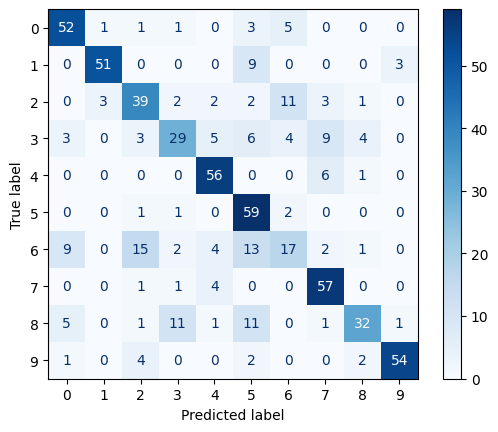

In [21]:
# Confusion Matrix of ResNet-34 CNN model.

# Get the true labels
true_labels = np.concatenate([y for x, y in test_dataset], axis=0)

# Make predictions
predictions = resnet_model.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(10))  # Adjust 'display_labels' as needed
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [20]:
# Model Performance Metric Analysis: Test Set Accuracy for First Model

resnet_test_loss, resnet_test_accuracy = resnet_model.evaluate(test_dataset)

print("Test loss {:.4f}".format(resnet_test_loss))
print("Test accuracy {:.4f}".format(resnet_test_accuracy))

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7360 - loss: 1.2793
Test loss 1.4697
Test accuracy 0.7079


Concluding Remarks

With the ResNet-34 model, we see that it yielded a training accuracy of 96.51% and a training loss of 0.0976 which is a better overall improvement from the first proposed model. We therefore reject the null hypothesis from the beginning of the exam and we have evidence to conclude that the ResNet-34 model generalizes the dataset much better than the first proposed CNN model. Before concluding the exam, we now provide some classified images from our model randomly, we will provide 9 correctly classified images and 9 incorrectly classified images.

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


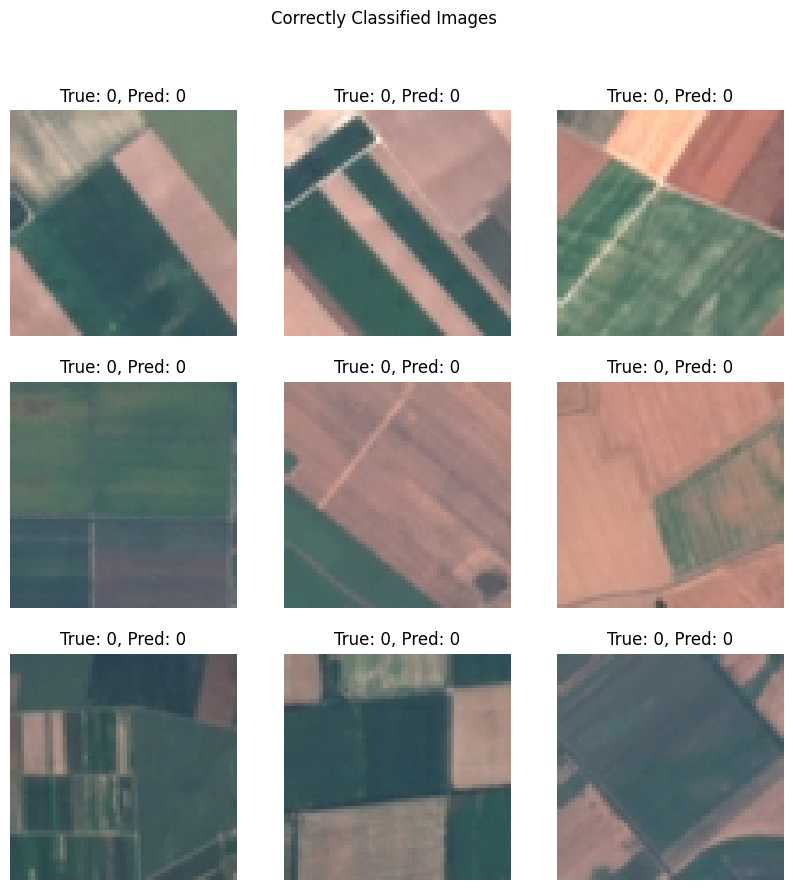

In [26]:
images = []
labels = []
for img, lbl in train_dataset:
    images.extend(img.numpy())  # Convert Tensor to NumPy array
    labels.extend(lbl.numpy())

images = np.array(images)
labels = np.array(labels)

# Reshape or transpose if needed
if images.shape[1] in [1, 3]:  # Channels-first format
    images = np.transpose(images, (0, 2, 3, 1))  # Convert to (batch_size, height, width, channels)

# Normalize if needed
if images.max() > 1:
    images = images / 255.0

# Predictions
predictions = resnet_model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = labels

# Find correct and incorrect classifications
correctly_classified = np.where(predicted_labels == true_labels)[0]
incorrectly_classified = np.where(predicted_labels != true_labels)[0]

# Display Correctly Classified Images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(correctly_classified[:9]):  # Display up to 9 images
    plt.subplot(3, 3, i + 1)
    image_to_display = images[idx]
    if image_to_display.ndim == 3 and image_to_display.shape[-1] == 1:  # Grayscale with channel
        image_to_display = image_to_display.squeeze(-1)
    plt.imshow(image_to_display, cmap='gray' if image_to_display.ndim == 2 else None)
    plt.title(f"True: {true_labels[idx]}, Pred: {predicted_labels[idx]}")
    plt.axis('off')
plt.suptitle("Correctly Classified Images")
plt.show()

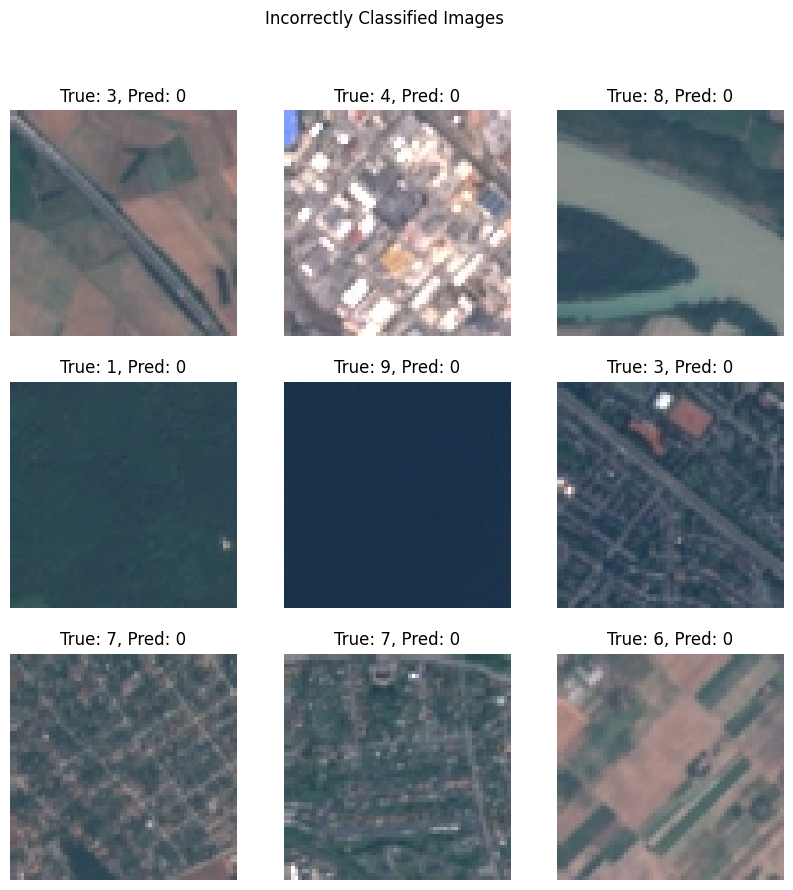

In [27]:
incorrectly_classified = np.where(predicted_labels != true_labels)[0]

# Display Correctly Classified Images
plt.figure(figsize=(10, 10))
for i, idx in enumerate(incorrectly_classified[:9]):  # Display up to 9 images
    plt.subplot(3, 3, i + 1)
    image_to_display = images[idx]
    if image_to_display.ndim == 3 and image_to_display.shape[-1] == 1:  # Grayscale with channel
        image_to_display = image_to_display.squeeze(-1)
    plt.imshow(image_to_display, cmap='gray' if image_to_display.ndim == 2 else None)
    plt.title(f"True: {true_labels[idx]}, Pred: {predicted_labels[idx]}")
    plt.axis('off')
plt.suptitle("Incorrectly Classified Images")
plt.show()

References

Chollet, Francois. Deep Learning with Python. Published 2021. Manning Publications Incorporated. Accessed 9 December 2024.

Koehrsen, Will. A Conceptual Explanation of Bayesian Hyperparameter Optimization for Machine Learning. Towards Data Science. Published June 2018. Accessed 12 December 2024.

Moon, Hojin. STAT 479 Lecture Notes and Course Materials. California State University, Long Beach. Accessed 7 December 2024.

Geron, Aurelion. Hands-On Machine Learning with Scikit-Learn, Keras, & Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems. Published October 2022. O'Reilly Media Incorporated. Accessed 7 December 2024.

Helber, Patrick, et al. EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Published August 2017. Accessed 10 December 2024.